# Project 5 - 01 : Data cleaning / EDA

This project aims to set up a tag suggestion system for the StackOverflow forum

## Data import

**Data :** https://data.stackexchange.com/stackoverflow/query/new  
**DB metadata :** https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede  
**Queries :** 
```SQL 
SELECT
    p.Id as id,
    p.Body as doc,
    p.Title as title,
    p.Tags as tags,
    p.CreationDate as creation_date,
    -- some additionnal metrics 
    p.Score as score,
    p.ViewCount as views,
    p.AnswerCount as answers,
    p.CommentCount as comments,
    p.FavoriteCount as favorites,
    p.LastActivityDate as last_activity_date
FROM posts p, PostTypes pt  
WHERE p.PostTypeId = pt.Id
AND pt.Name  = 'Question'
AND p.Tags IS NOT NULL
AND p.FavoriteCount > 0
AND p.Score > 0
AND p.CreationDate <= '01-01-2021'  -- to retrieve recent posts
-- to make several queries without having duplicates
AND p.Id >= XXX  
AND p.Id < XXX
```
After looking at the database metadata, I selected the columns that seemed relevant (questions text, tags, date, and some metrics to try to filter according to the relevance of the questions)  
I filtered the posts table to retrieve only the "Questions" with tags and a score/number of favorites higher than 0  
I also filtered by ID to have about 50k rows per query, due to StackExchange limitations.

In [1]:
%pylab inline
import os, re
from collections import defaultdict
import pandas as pd
import matplotlib.dates as mdates
import missingno as msno
import seaborn as sns
import nltk
import joblib
import operator
from nltk.stem import lancaster, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext pycodestyle_magic
%flake8_on --max_line_length 140

In [3]:
data_dir = './P5_04_data'


def load_multi_csv(dir_path):
    """ Load all CSV files in the given directory
    args:
        dir_path: str - path of the folder containing CSV files
    return:
        df: DataFrame
    """
    df_list = []
    print('##### Loaded files ######')
    for filename in os.listdir(dir_path):
        if filename.split('.')[-1] == 'csv' and 'p00' in filename:
            file_path = os.path.join(dir_path, filename)
            current_data = pd.read_csv(file_path, sep=',', index_col='id')
            print('>', filename)
            df_list.append(current_data)
    df = pd.concat(df_list)
    print(f'Dataset : {df.shape[0]} rows / {df.shape[1]} columns')
    return df


df = load_multi_csv(data_dir)

##### Loaded files ######
> SO_posts_p00_fin2020.csv
Dataset : 50000 rows / 10 columns


In [4]:
df.shape

(50000, 10)

In [5]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 65526356 to 62155957
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   doc                 50000 non-null  object
 1   title               50000 non-null  object
 2   tags                50000 non-null  object
 3   creation_date       50000 non-null  object
 4   score               50000 non-null  int64 
 5   views               50000 non-null  int64 
 6   answers             50000 non-null  int64 
 7   comments            50000 non-null  int64 
 8   favorites           50000 non-null  int64 
 9   last_activity_date  50000 non-null  object
dtypes: int64(5), object(5)
memory usage: 4.2+ MB
None


,doc,title,tags,creation_date,score,views,answers,comments,favorites,last_activity_date
id,,,,,,,,,,
65526356,<p>I've created the following graph:</p>\n<pre...,"Pyspark + Graphframes: ""recursive"" message agg...",<python><apache-spark><pyspark><apache-spark-s...,2020-12-31 23:54:26,1,150,1,1,1,2021-01-01 17:00:26
65526323,"<p>I want to setup 3 radio inputs like below ,...",Set if conditions based on radio input value,<javascript><jquery>,2020-12-31 23:45:17,1,36,2,0,1,2021-01-01 03:23:23
65526301,<p>I have a dataframe <code>df</code> where:</...,How do I create new rows based on cell value?,<r><excel>,2020-12-31 23:38:35,1,42,1,0,1,2020-12-31 23:54:48
65526283,<p>So I built a program that prints out the lo...,How to skip lines when printing output from Pa...,<python><ssh><paramiko>,2020-12-31 23:36:07,2,90,1,0,1,2021-01-01 10:52:02
65526149,<p>I'm trying to get more useful output from <...,"Pytest: customize short test summary info, rem...",<python><pytest>,2020-12-31 23:02:24,3,440,1,0,2,2021-01-03 12:50:11


<AxesSubplot:>

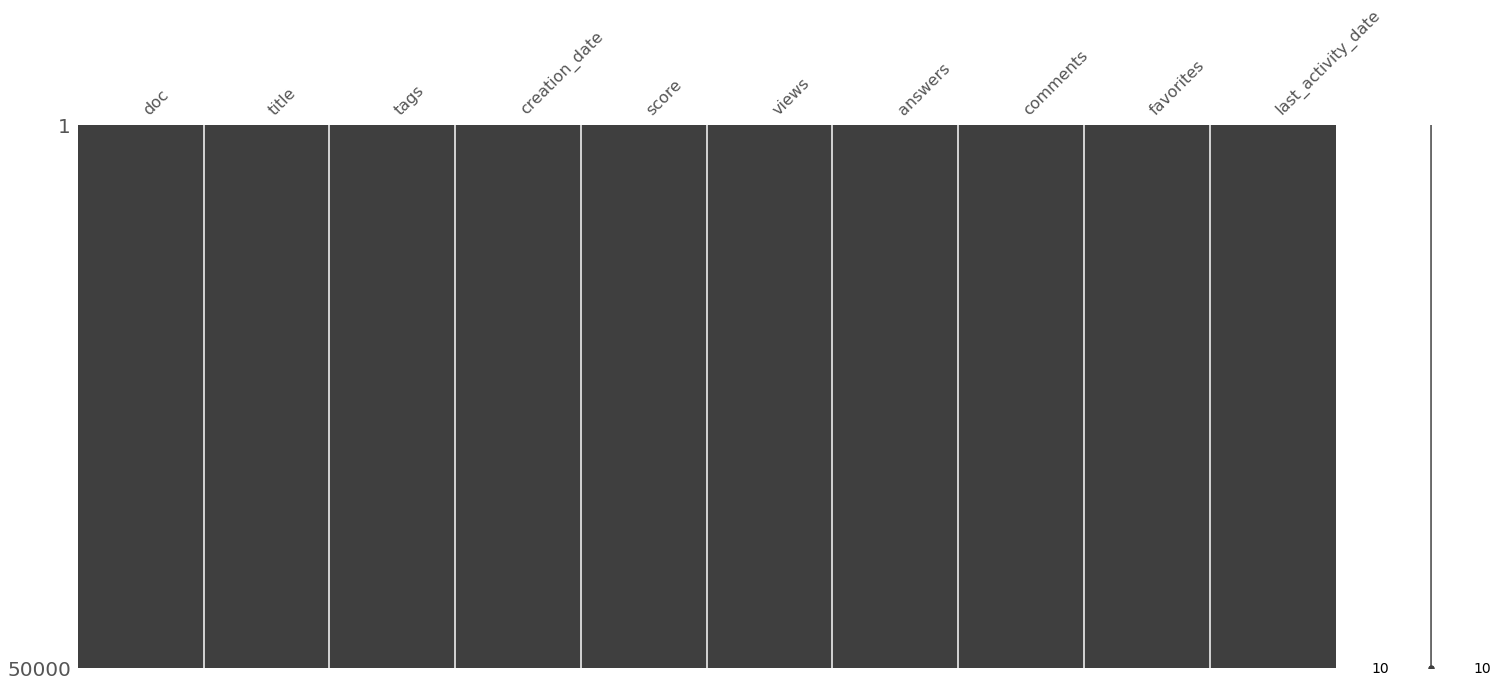

In [6]:
msno.matrix(df)

## Data cleaning
- Types correction
- Removing html tags in each text document and '<', '>' in the tags
- Counting tags per document
- Flattening the tags list in a new df
- Counting words per document

In [7]:
# Types correction
for col in df.columns:
    # dates as DateTime
    if any([sub in col for sub in ['date']]):
        df[col] = df[col].astype('datetime64')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 65526356 to 62155957
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   doc                 50000 non-null  object        
 1   title               50000 non-null  object        
 2   tags                50000 non-null  object        
 3   creation_date       50000 non-null  datetime64[ns]
 4   score               50000 non-null  int64         
 5   views               50000 non-null  int64         
 6   answers             50000 non-null  int64         
 7   comments            50000 non-null  int64         
 8   favorites           50000 non-null  int64         
 9   last_activity_date  50000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(5), object(3)
memory usage: 4.2+ MB


In [9]:
# replace HTML tags by ' '
df['doc'] = [re.sub("<.*?>", ' ', x) for x in df.doc]
# add title to the doc body
df['doc'] = df.title + " " + df.doc
# get the list of values (tags) between < and >
df['tags'] = [re.findall("<(.*?)>", x) for x in df.tags]

In [67]:
# counting tags
df['tags_cnt'] = [len(x) for x in df.tags]
# counting words
df['words_cnt'] = [len(x.split()) for x in df['doc']]

In [10]:
# Null values
df.isnull().sum()

doc                   0
title                 0
tags                  0
creation_date         0
score                 0
views                 0
answers               0
comments              0
favorites             0
last_activity_date    0
tags_cnt              0
dtype: int64

## EDA

In [68]:
df.describe()

,score,views,answers,comments,favorites,tags_cnt,words_cnt
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.89600,818.574540,1.344560,2.037560,1.311540,3.305360,214.857500
std,6.65403,3611.820654,1.241334,2.941993,1.314792,1.230912,201.380163
min,1.00000,8.000000,0.000000,0.000000,1.000000,1.000000,12.000000
25%,1.00000,67.000000,1.000000,0.000000,1.000000,2.000000,102.000000
50%,2.00000,160.000000,1.000000,1.000000,1.000000,3.000000,161.000000
75%,3.00000,508.000000,2.000000,3.000000,1.000000,4.000000,258.000000
max,478.00000,253612.000000,41.000000,46.000000,135.000000,5.000000,3966.000000


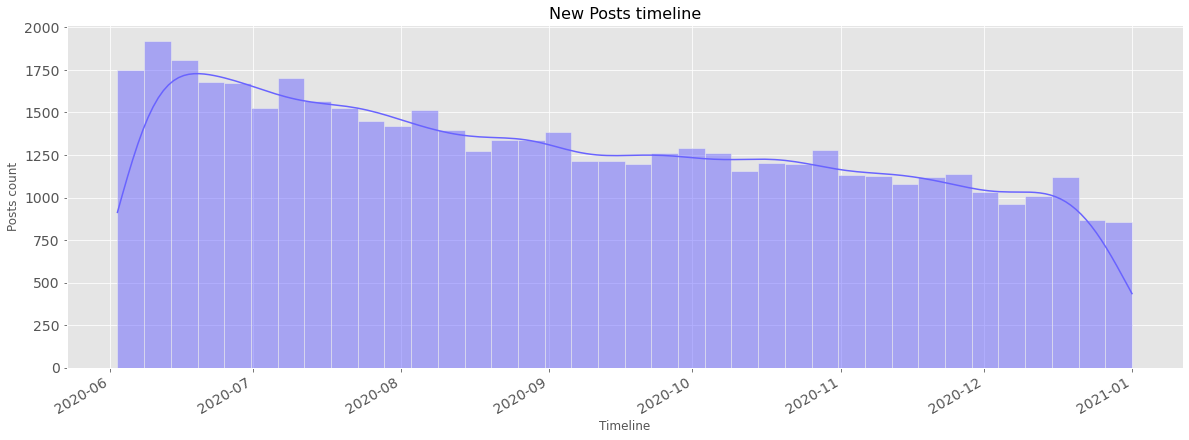

In [13]:
f, ax = plt.subplots(figsize=(20, 7))
sns.histplot(data=df['creation_date'], kde=True, ax=ax, color='#6963ff')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.title('New Posts timeline', fontsize=16)
plt.xlabel('Timeline', fontsize=12)
plt.ylabel('Posts count', fontsize=12)
plt.show()

In [14]:
print(f'Dataset contain data from {df.creation_date.min().strftime("%m/%d/%Y")} to {df.creation_date.max().strftime("%m/%d/%Y")}')  # noqa (too long)

Dataset contain data from 06/02/2020 to 12/31/2020


In [65]:
print(f"An average of {df['creation_date'].dt.strftime('%d/%y').value_counts().mean():.0f} questions per months")

An average of 1613 questions per months


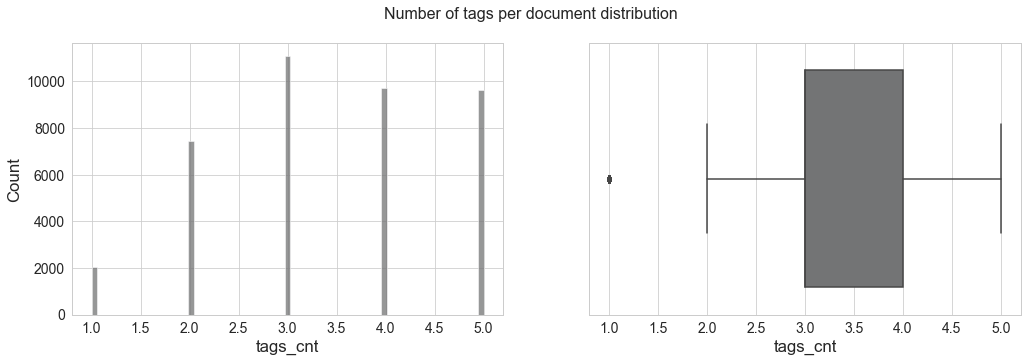

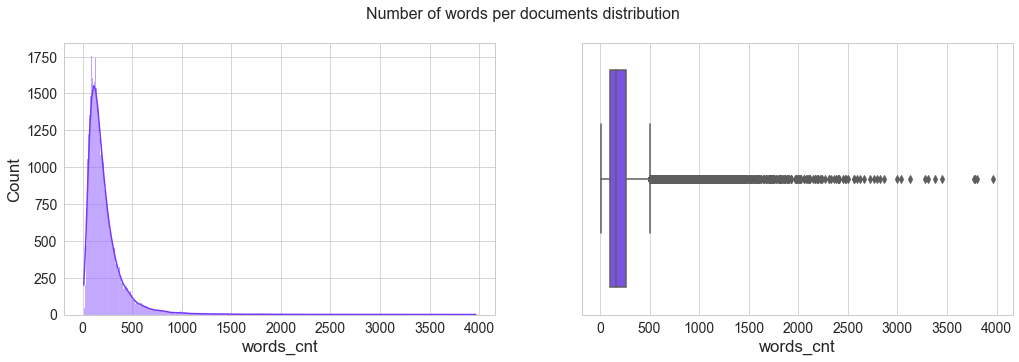

In [53]:
def plot_hist_box(data, title, figsize=(17, 5), kde=True, color='#19baff'):
    """Plot hitogram and box plot of a numeric Series
    args:
        data (Series(int)): Numeric values
        title (str) : figure title
        figsize: (tuple(int, int), optionnal) def:(17,5) - figure size
        kde (bool) def=True - display kernel density estimation on the hitogram
    """
    f, axes = plt.subplots(1, 2, figsize=(17, 5))
    f.suptitle(title, fontsize=16)
    sns.histplot(data=data, color=color, ax=axes[0], kde=kde)
    sns.boxplot(x=data, color=color, ax=axes[1])
    plt.show()


sns.set_style("whitegrid")
plot_hist_box(df['tags_cnt'], 'Number of tags per document distribution', kde=False, color='#737475')
plot_hist_box(df['words_cnt'], 'Number of words per documents distribution', color='#7438ff')

In [16]:
mlb_tags = MultiLabelBinarizer()
mlb_tags.fit(corpus_df['tags'])
binary_tags = pd.DataFrame(mlb_tags.transform(corpus_df['tags']), columns=mlb_tags.classes_)
tags_disrib = binary_tags.sum(axis=0).sort_values(ascending=False)

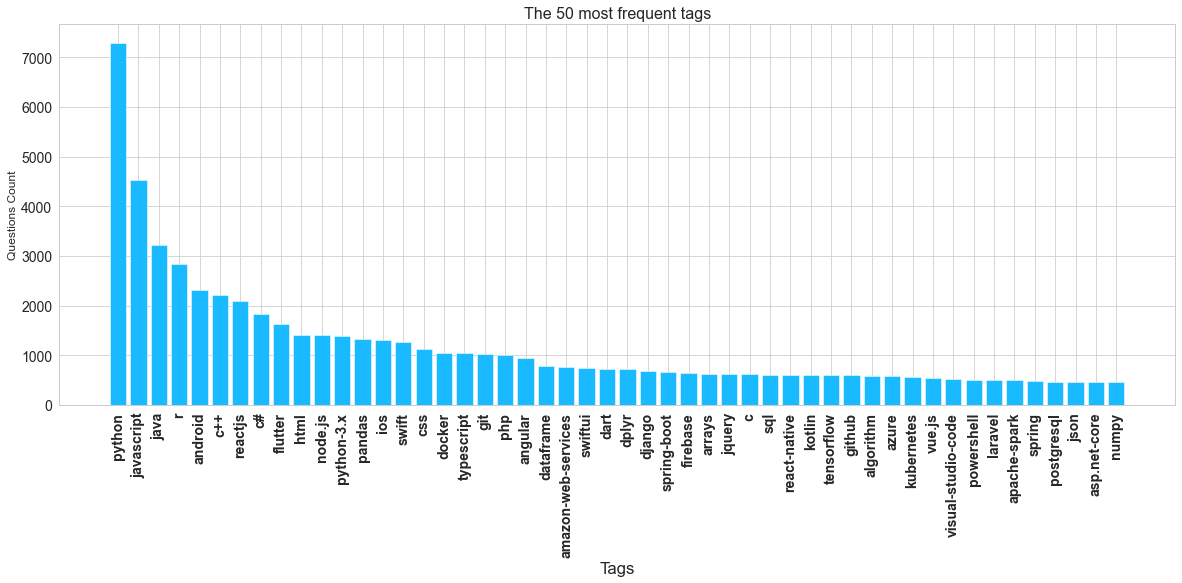

In [17]:
plt.subplots(figsize=(20, 7))
plt.bar(x=tags_disrib.head(50).index, height=tags_disrib.head(50).values, color='#19baff')
plt.title('The 50 most frequent tags', fontsize=16)
plt.xticks(rotation='vertical', fontweight='bold')
plt.xlabel('Tags')
plt.ylabel('Questions Count', fontsize=12)
plt.show()

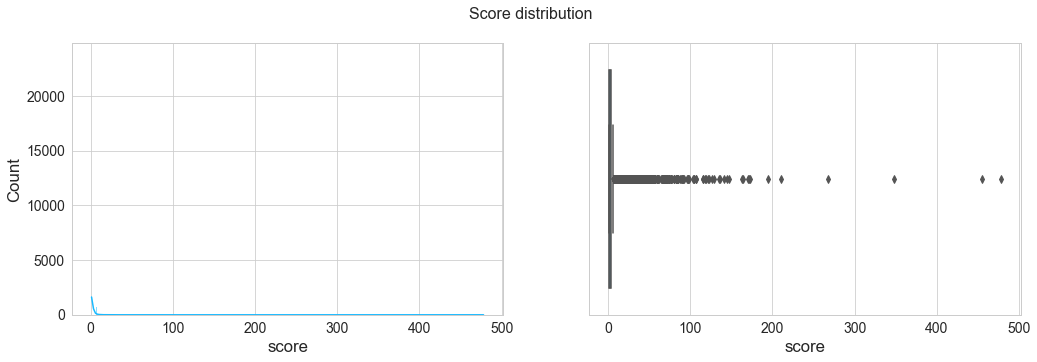

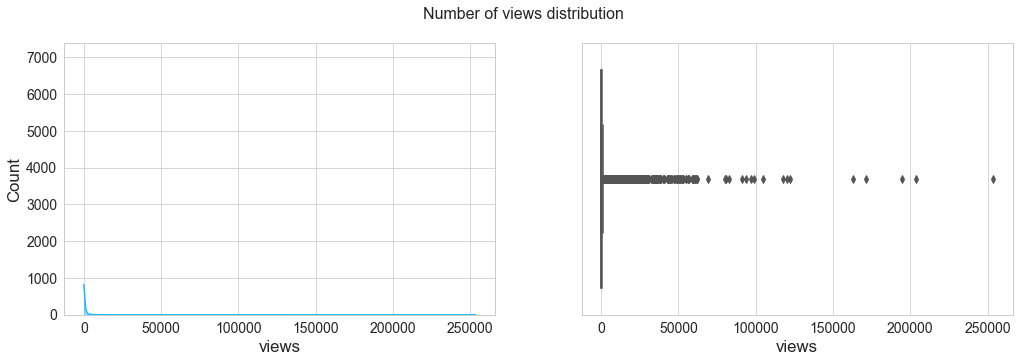

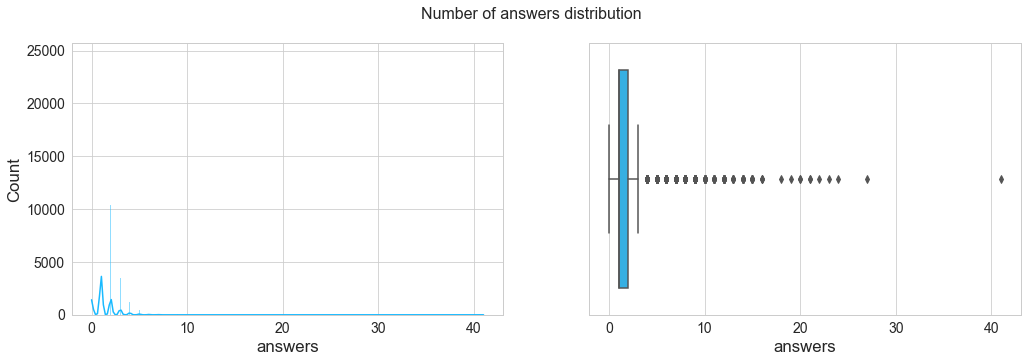

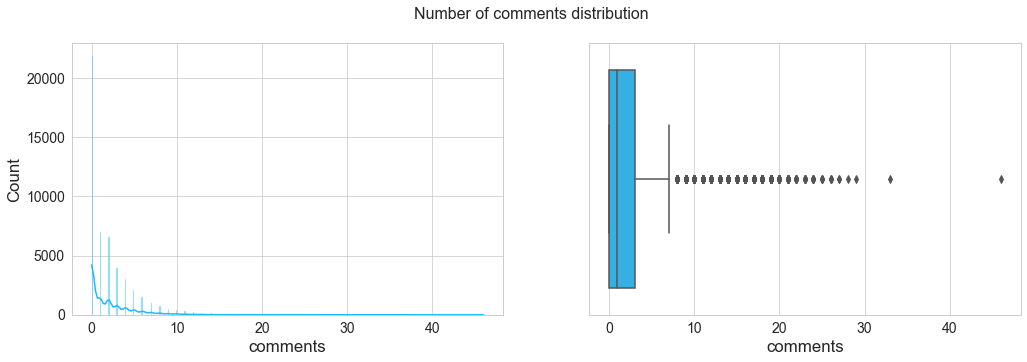

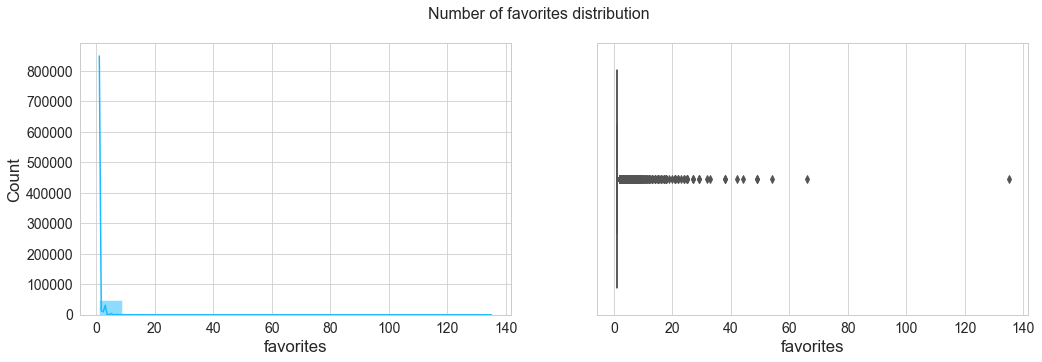

In [56]:
# addtionnal metrics
plot_hist_box(df['score'], 'Score distribution')
plot_hist_box(df['views'], 'Number of views distribution')
plot_hist_box(df['answers'], 'Number of answers distribution')
plot_hist_box(df['comments'], 'Number of comments distribution')
plot_hist_box(df['favorites'], 'Number of favorites distribution')

## Dataset reduction

In [11]:
# Creation of a df without the metrics columns
corpus_df = df[['doc', 'tags', 'tags_cnt']].copy()

### Infrequent tags removal

In [18]:
print(f"{tags_disrib.shape[0]:{5}} unique tags")
# tags that appears once
print(f"{tags_disrib[tags_disrib == 1].shape[0]:{5}} tags that only appears once "
      f"({tags_disrib[tags_disrib == 1].shape[0] / tags_disrib.shape[0] * 100:.2f} % of tags)")
# tags with more than100 occurences
print(f"{tags_disrib[tags_disrib >= 100].shape[0]:{5}} tags with 100 occurences or more "
      f"({tags_disrib[tags_disrib >= 100].shape[0] / tags_disrib.shape[0] * 100:.2f} % of tags)")

14618 unique tags
 6452 tags that only appears once (44.14 % of tags)
  207 tags with 100 occurences or more (1.42 % of tags)


In [19]:
mf_tags_freq = {}
# iteration on number of tags with more than 100 occurence with a step of 5
for n in range(0, 207, 5):
    # Proportion of the n most frequent tags in the corpus of questions
    # (1 - (number of row not containing the n most frequent tags) / (number of questions)) * 100
    mf_tags_freq[n] = (1 - (sum((binary_tags[tags_disrib[:n].index] == 0).all(1)) / corpus_df.shape[0])) * 100

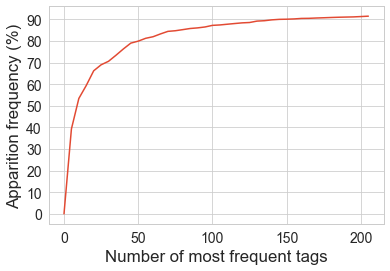

In [20]:
nb_mf_tags, freq = zip(*mf_tags_freq.items())
plt.plot(nb_mf_tags, freq)
plt.xticks(range(0, 207, 50))
plt.xlabel("Number of most frequent tags")
plt.yticks(range(0, 100, 10))
plt.ylabel("frequency (%)")
plt.show()

In [21]:
print(f"The 50 most frequent tags appears in {mf_tags_freq[50]:.2f} % of questions")

The 50 most frequent tags appears in 79.89 % of questions


There are a lot of different tags but many are unique, there are few really frequent tags.  
So I only get the 50 most frequent

In [22]:
top_50_tags = list(tags_disrib[:50].index)

In [23]:
# reducing tags
corpus_df['reduced_tags'] = corpus_df.tags.apply(lambda tags: [t for t in tags if t in top_50_tags])
# counting reduced tags
corpus_df['reduced_tags_cnt'] = [len(x) for x in corpus_df.reduced_tags]
# checking for document without tags
print(f"{corpus_df[corpus_df['reduced_tags_cnt'] == 0].shape[0]} documents without tags")

10056 documents without tags


In [24]:
corpus_df = corpus_df[~(corpus_df['reduced_tags_cnt'] == 0)]
print(f"{corpus_df.shape[0]} documents remaining")

39944 documents remaining


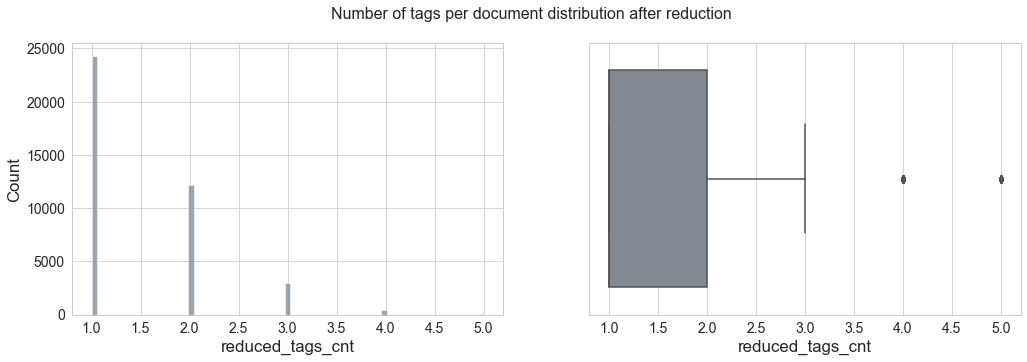

In [25]:
plot_hist_box(corpus_df['reduced_tags_cnt'], 'Number of tags per document distribution after reduction', kde=False, color='#7f8994')

## POS Tags Analysis

The nouns are the words which give the most information on the subject of the questions.  

In [26]:
def postags_analysis(corpus):
    """ Detects POS tag of each word in the corpus and return a stats df
    args:
        corpus: list(str) - List of text documents
    return:
        Series - sorted counting of each tag in the corpus
    """
    corpus_stats = []
    for doc in corpus:
        # standard tokenization and POS tags detection on the tokens
        # then compute doc stats and add them to the corpus stats
        doc_tokens = [tkn for tkn in nltk.word_tokenize(doc) if len(tkn) > 1]
        doc_stats = pd.DataFrame(nltk.pos_tag(doc_tokens), columns=['postag', 'cnt'])['cnt'].value_counts()
        corpus_stats.append(doc_stats)
    corpus_stats = pd.concat(corpus_stats)
    return pd.DataFrame(corpus_stats.reset_index().groupby('index')['cnt'].sum()).sort_values(by='cnt', ascending=False)

Dict to map the acronyms of the POS tagger with their descriptions (descriptions are from the nltk doc)

In [27]:
# Penn Treebank Projetct POS tags
mapping_postag = {
    'CC': 'Coordinating conjunction',
    'CD': 'Cardinal number',
    'DT': 'Determiner',
    'EX': 'Existential there',
    'FW': 'Foreign word',
    'IN': 'Preposition or subordinating conjunction',
    'JJ': 'Adjective',
    'JJR': 'Adjective, comparative',
    'JJS': 'Adjective, superlative',
    'LS': 'List item marker',
    'MD': 'Modal',
    'NN': 'Noun, singular or mass',
    'NNS': 'Noun, plural',
    'NNP': 'Proper noun, singular',
    'NNPS': 'Proper noun, plural',
    'PDT': 'Predeterminer',
    'POS': 'Possessive ending',
    'PRP': 'Personal pronoun',
    'PRP$': 'Possessive pronoun',
    'RB': 'Adverb',
    'RBR': 'Adverb, comparative',
    'RBS': 'Adverb, superlative',
    'RP': 'Particle',
    'SYM': 'Symbol',
    'TO': 'to',
    'UH': 'Interjection',
    'VB': 'Verb, base form',
    'VBD': 'Verb, past tense',
    'VBG': 'Verb, gerund or present participle',
    'VBN': 'Verb, past participle',
    'VBP': 'Verb, non-3rd person singular present',
    'VBZ': 'Verb, 3rd person singular present',
    'WDT': 'Wh-determiner',
    'WP': 'Wh-pronoun',
    'WP$': 'Possessive wh-pronoun',
    'WRB': 'Wh-adverb',
}

In [28]:
%%time
postag_stats = postags_analysis(corpus_df['doc'])

Wall time: 14min 13s


In [29]:
postag_stats['descr'] = postag_stats.index.map(mapping_postag)
postag_stats

,cnt,descr
index,,
NN,2671200,"Noun, singular or mass"
NNP,1087882,"Proper noun, singular"
JJ,923529,Adjective
IN,676209,Preposition or subordinating conjunction
DT,465626,Determiner
CD,351053,Cardinal number
VB,337917,"Verb, base form"
NNS,335730,"Noun, plural"
RB,291782,Adverb


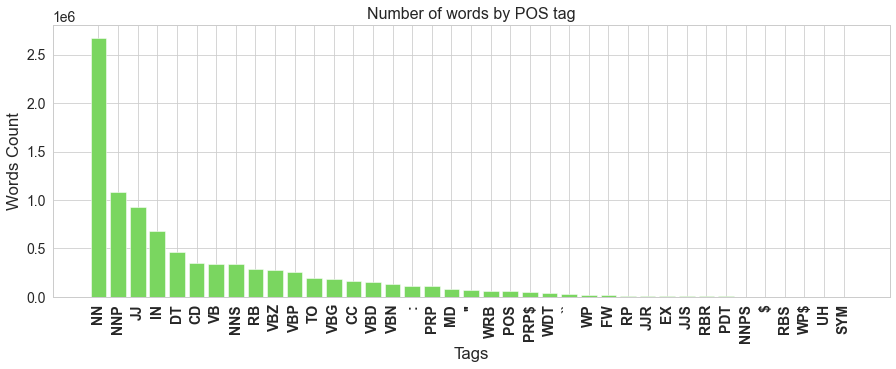

In [30]:
plt.subplots(figsize=(15, 5))
plt.bar(x=postag_stats.index, height=postag_stats['cnt'], color='#7ad660')
plt.title('Number of words by POS tag', fontsize=16)
plt.xticks(rotation='vertical', fontsize=14, fontweight='bold')
plt.xlabel('Tags')
plt.ylabel('Words Count')
plt.show()

We can see that the majority of words are nouns but there are also many other types of words and alone char which are not necessarily useful in understanding the context of the documents.

## Stop Words
English stop words from nltk

In [31]:
stop_words = nltk.corpus.stopwords.words('english')
print(stop_words)
print(f"\n{len(stop_words)} words in the nltk english stopwords list")

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Tokenization

In [32]:
class TransformTokenizer:
    """ 'All in one' tokenizer. Tokenize and normalize (lemmatize or stem) a text corpus, depending on the given mode
    A RegEx can be used for the tokenisation.
    It's possible to use a custom lemmatizer/stemmer, defaults are WordNetLemmatizer or LancasterStemmer
    It's also possible to remove a custom list of stop words, or nltk stopwords for a given langage
    """
    def __init__(self, mode='lemma', normalizer=None, regex_pattern=None,
                 sw='english', rmv_postags=[]):
        """
        args:
            mode: {'lemma', 'stem'}, default='lemma' - normalization mode
            transformer: obj default=None - optional custom normalizer
            regexp_pattern: str, default=None - optional regxp for tokenization
            sw_lang: str, default='english' - stop words langage
            rmv_postags: list(str) - unused postags, to remove in the corpus
        """
        if mode and mode not in ['lemma', 'stem']:
            raise ValueError(":mode: must be 'lemma', 'stem' or None only.")
        # define normalizer (custom or default) depending on the given mode
        self.mode = mode
        self.normalizer = normalizer or WordNetLemmatizer() if self.mode == 'lemma' else lancaster.LancasterStemmer()
        # define rexeptokenizer if pattern
        self.regexptokenizer = nltk.RegexpTokenizer(regex_pattern) if regex_pattern else None
        # define stop words
        if sw and type(sw) == str:
            self.stop_words = nltk.corpus.stopwords.words(sw)
        elif sw and type(sw) == list:
            self.stop_words = sw
        else:
            self.stop_words = []
        self.unused_postags = rmv_postags or []

    def __call__(self, doc):
        """
        args:
            doc: str - text document to tokenize
        output:
            list - tokenized document
        """
        # tokenization
        if self.regexptokenizer:
            tokens = self.regexptokenizer.tokenize(doc)
        else:
            tokens = nltk.word_tokenize(doc)
        # unused POStags removal
        if self.unused_postags and tokens:
            postags = nltk.pos_tag(tokens)
            tokens = [x[0] for x in postags if x[1] not in self.unused_postags]
        # Normalisation + stop words removal
        if self.mode == 'lemma':
            tokens = [self.normalizer.lemmatize(tkn) for tkn in tokens if tkn not in self.stop_words]
        elif self.mode == 'stem':
            tokens = [self.normalizer.stem(tkn) for tkn in tokens if tkn not in self.stop_words]
        return tokens

In [33]:
notnounstags = [tag for tag in mapping_postag.keys() if tag not in ['NN', 'NNP', 'NNPS', 'NNS']]
tokenizer = TransformTokenizer(
    mode='lemma',
    regex_pattern=r"(?u)\b\w\w+\b",
    sw=stop_words,
    rmv_postags=notnounstags
)

This tokenizer instance do several things : it tokenize using a regex, remove the custom stop words list and lemmatize tokens using WordNetLemmatizer

In [34]:
%%time
# add tokenized corpus as a new df column
corpus_df['tokens'] = [tokenizer(x) for x in corpus_df['doc']]

Wall time: 12min 51s


In [35]:
# counting tokens per document
corpus_df['tokens_cnt'] = [len(x) for x in corpus_df['tokens']]

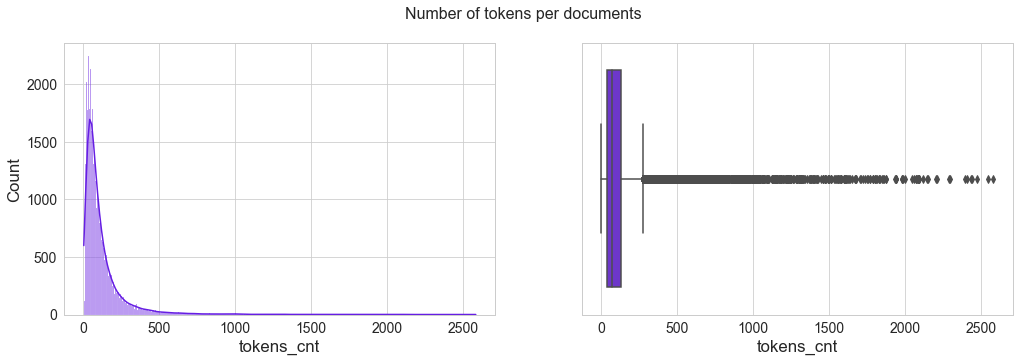

In [36]:
plot_hist_box(corpus_df['tokens_cnt'], 'Number of tokens per documents', color='#661ee3')

## Vectorization

In [37]:
def rank_terms(matrix, voc):
    """Sort the terms by their matrix weight
    args:
        matrix: csr_matrix - vectorized corpus matrix
        voc: list(str) - corpus vocabulary
    return:
        list - sorted terms
    """
    # get the sums over each column
    sums = matrix.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(voc):
        weights[term] = sums[0, col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

### Document-Term Matrix
**Bag of word model** : each document is represented by a *bag of word* : vector in a m-dimensional coordinate space, where m is number of unique terms across all documents (this set of terms is called the *corpus vocabulary*).  
Since each document can be represented as a term vector, we can stack these vectors to create a full *document-term matrix*.

In [69]:
vect_params = {
    'lowercase': True,
    'tokenizer': tokenizer,
    'ngram_range': (1, 1),  # (1,1)=unigrams, (1,2)=unigrams+bigrams, (2,2)=bigrams
    'max_df': .80,  # default=1.0
    'min_df': 5  # default=1
}
print(f"{corpus_df.shape[0]} documents containing an average of {corpus_df['tokens_cnt'].mean():.2f} words")

39944 documents containing an average of 120.73 words


In [70]:
%%time
bow_vectorizer = CountVectorizer(**vect_params)
dt_matrix = bow_vectorizer.fit_transform(corpus_df['doc'])
print(type(dt_matrix), dt_matrix.shape)

<class 'scipy.sparse.csr.csr_matrix'> (39944, 18307)
Wall time: 13min 32s


In [40]:
corpus_voc = bow_vectorizer.get_feature_names()
print(f"{len(corpus_voc)} unique words in the corpus vocabulary")

9982 unique words in the corpus vocabulary


In [41]:
# storing the doc-term matrix in the df
corpus_df['bow'] = list(dt_matrix)

In [42]:
top_terms_dtmatrix = rank_terms(dt_matrix, corpus_voc)
for x in top_terms_dtmatrix[:20]:
    print(f"{top_terms_dtmatrix.index(x) + 1:02d} - {x[0]} ({x[1]})")

01 - quot (326571)
02 - gt (163411)
03 - lt (110929)
04 - class (36794)
05 - data (35368)
06 - error (30438)
07 - file (29287)
08 - value (28013)
09 - code (27603)
10 - name (26069)
11 - function (25811)
12 - java (22169)
13 - import (21450)
14 - return (20587)
15 - div (19118)
16 - com (19031)
17 - type (18626)
18 - id (18438)
19 - app (17431)
20 - user (17320)


### TF-IDF
We can improve the usefulness of the document-term matrix by giving more weight to the more "important" terms.   
The most common normalisation is *term frequency–inverse document frequency* (TF-IDF).

In [43]:
%%time
tfidf_vectorizer = TfidfVectorizer(**vect_params)
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_df['doc'])
tfidf_matrix.shape

Wall time: 12min 40s


(39944, 9982)

In [44]:
corpus_voc = tfidf_vectorizer.get_feature_names()
print(f"{len(corpus_voc)} unique words in the corpus")

9982 unique words in the corpus


In [45]:
# storing the tf-idf matrix
corpus_df['tfidf'] = list(tfidf_matrix)

In [46]:
top_terms_tfidf = rank_terms(tfidf_matrix, corpus_voc)
for x in top_terms_tfidf[:20]:
    print(f"{top_terms_tfidf.index(x) + 1:02d} - {x[0]} ({x[1]:.2f})")

01 - quot (4041.57)
02 - gt (2234.65)
03 - lt (1661.54)
04 - data (967.02)
05 - file (891.80)
06 - value (871.91)
07 - error (827.31)
08 - class (821.20)
09 - function (808.78)
10 - code (741.59)
11 - name (667.21)
12 - app (586.98)
13 - import (575.70)
14 - type (552.34)
15 - way (550.25)
16 - list (547.22)
17 - user (540.68)
18 - return (537.94)
19 - int (536.76)
20 - image (536.09)


In [47]:
joblib.dump(corpus_df, "P5_04_data/dataset.pkl")

['P5_04_data/dataset.pkl']

In [48]:
joblib.dump((corpus_voc, bow_vectorizer, tfidf_vectorizer), "P5_04_data/fitted-vectorizers.pkl")

['P5_04_data/fitted-vectorizers.pkl']